In [1]:
!pip install monai

     |████████████████████████████████| 721 kB 4.5 MB/s            


In [2]:
import os
import monai
import torch,torchvision
import skimage
import numpy as np 
import pandas as pd 
from glob import glob
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Spacingd,
    Resized,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    ToTensor,
    ToTensord,
    Orientationd,
    NormalizeIntensityd,
    RandRotated,
    RandAxisFlipd,
    RandFlipd,
    AdjustContrastd,
)
print_config()


MONAI version: 0.8.1
Numpy version: 1.20.3
Pytorch version: 1.9.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 8.2.0
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.1
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.15.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
#We will create two arrays containing file name of Brain MRI and there respective Masks.

# Mask Files
mask_files = sorted(glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*'))

# Brain MRI Images
training_files = []
for path in mask_files:
    training_files.append(path.replace('_mask',''))

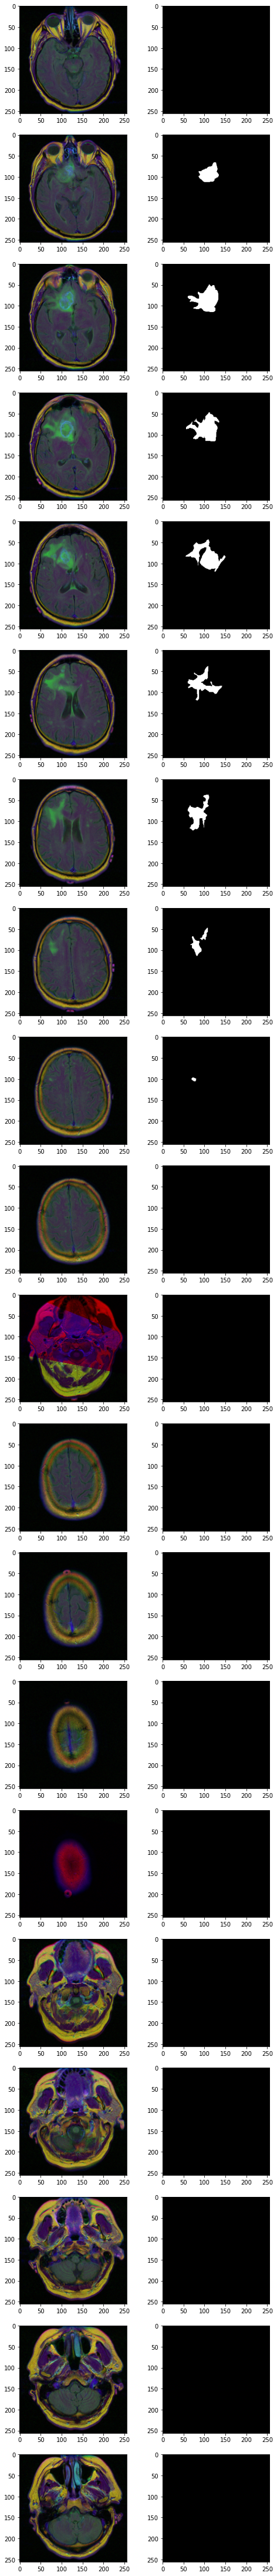

In [4]:
#Visualization of data

rows = 20
fig,ax = plt.subplots(rows,2,figsize=(8,80))
for i in range(rows):
    read1 = plt.imread(training_files[i])
    read2 = plt.imread(mask_files[i])
    ax[i,0].imshow(read1)
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

In [5]:
#So we can see that there are cases in which we dont have masks these cases can lead to difficulty in the learninig of our model.

In [6]:
# will tell us if a image has mask or not
def is_mask(path):
    mask = plt.imread(path)
    if np.max(mask) != 0.0:
        return 1
    else:
        return 0

In [7]:
df = pd.DataFrame({'training_files':training_files,'mask_files':mask_files})
df['mask'] = df['mask_files'].apply(lambda x: is_mask(x))

In [8]:
df.head()

training_files  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   

                                          mask_files  mask  
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     0  
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1

In [9]:
df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [10]:
data = df[df['mask']==1]

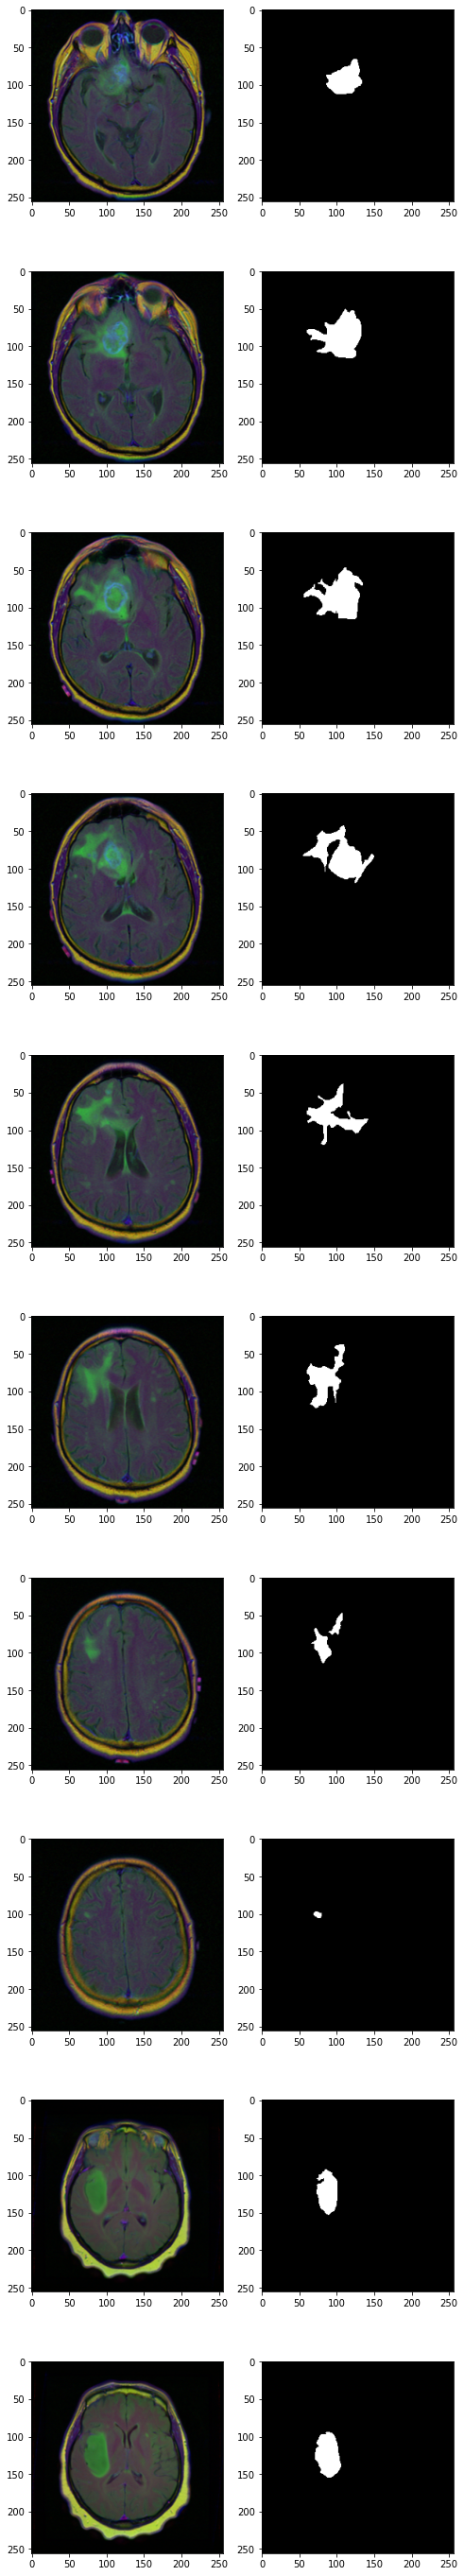

In [11]:
rows = 10
fig,ax = plt.subplots(rows,2,figsize=(8,50))
for i in range(rows):
    read1 = plt.imread(data['training_files'].iloc[i])
    read2 = plt.imread(data['mask_files'].iloc[i])
    ax[i,0].imshow(read1,cmap='gray')
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

Converting the images from .tff to .nii format since it is a very efficient way when using monai or with medical data in general.

Converting the colored images into GrayScale images since It will reduce the model coplexity a lot.

In [12]:
# Creating Dir to store the converted files
dir = './new_data'
mask_out_path = './new_data/mask'
input_out_path = './new_data/input'
os.mkdir(dir)
os.mkdir(mask_out_path)
os.mkdir(input_out_path)

In [13]:
# This library will help in conversion
!pip install imio

  Preparing metadata (setup.py) ... done
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34546 sha256=e8869d6440c300575dac404a2677e6564847eed03c7c50511197df06bcd5b29a
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj


In [14]:
from imio import load, save

In [15]:
# Traning Files
for path in data['training_files']:
    img = plt.imread(path)
    img = skimage.color.rgb2gray(img)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(input_out_path,name))

In [16]:
# Mask Files
for path in data['mask_files']:
    img = plt.imread(path)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(mask_out_path,name))

Preprocessing & Data Augmentation


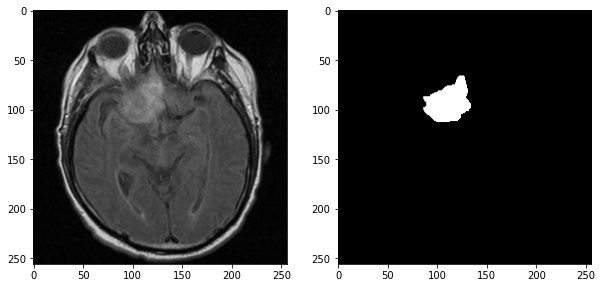

In [17]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
img = skimage.color.rgb2gray(plt.imread(data['training_files'].iloc[0]))
mask = plt.imread(data['mask_files'].iloc[0])
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,cmap='gray')



The size of the image is 250x250 which is large and can cause issues while fitting in the GPU Memory.

Also, It is difficult to see the tumor in the Brain MRI. To resolve this we can strach contrast accordingly.


In [18]:
# First we have to get that .nii data
filenames = []
img = sorted(glob('./new_data/input/*'))
mask = sorted(glob('./new_data/mask/*'))
for i in range(len(img)):
    filenames.append({'img':img[i],'mask':mask[i]})

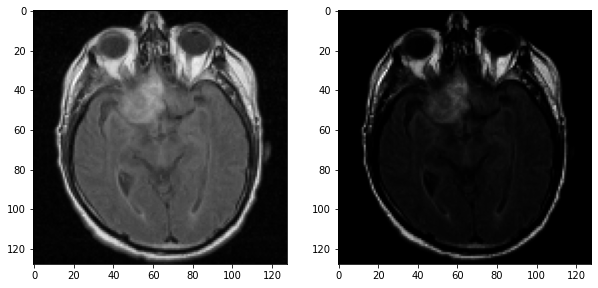

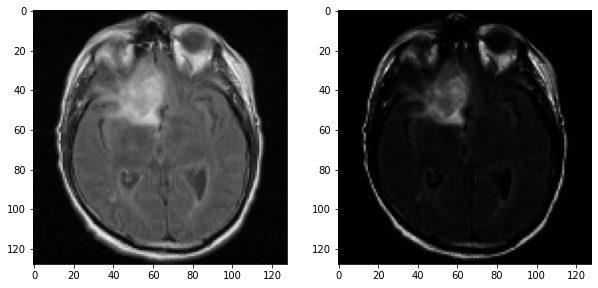

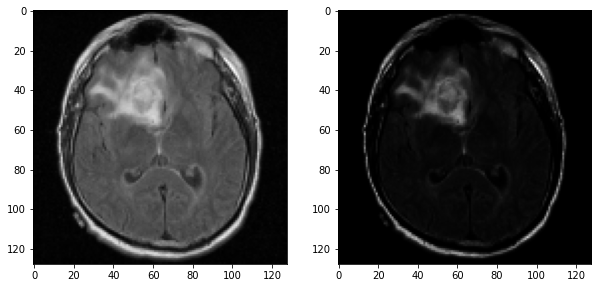

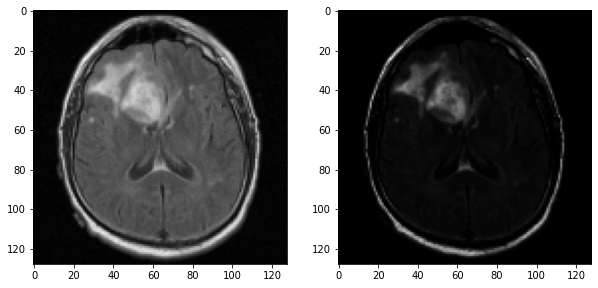

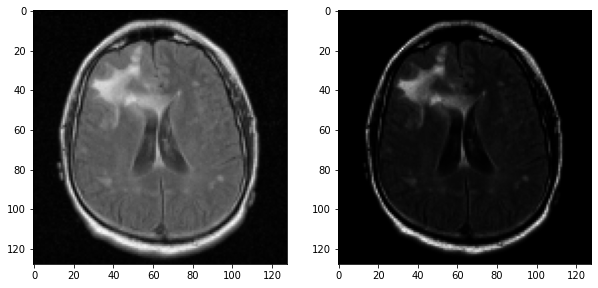

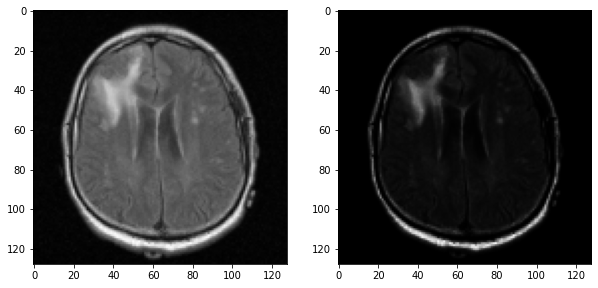

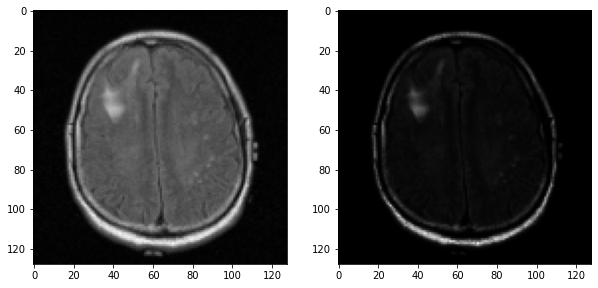

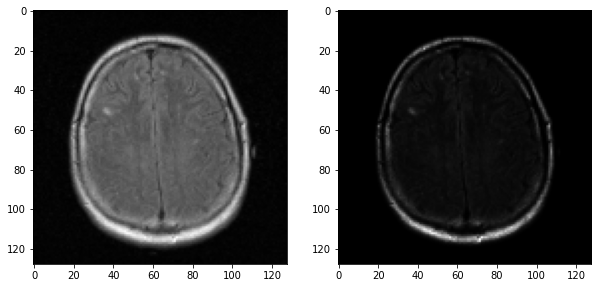

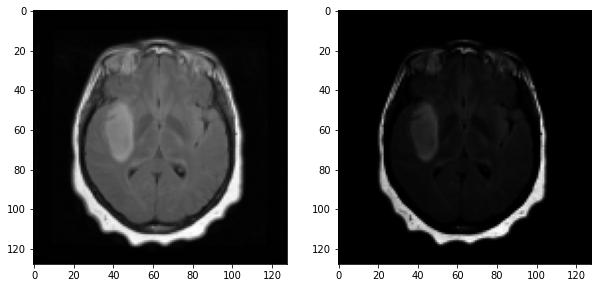

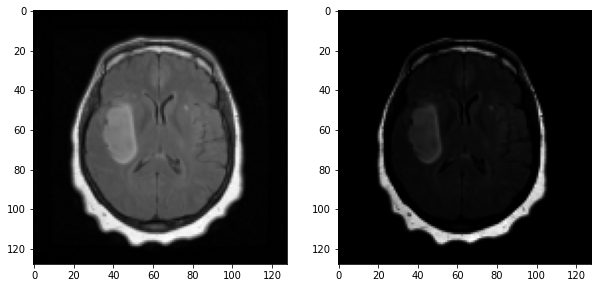

In [19]:
for i in range(0,10):
  li = LoadImaged(keys=['img','mask'])
  li_img = li(filenames[i])
  add = AddChanneld(keys=['img','mask'])
  add_img = add(li_img)
  res = Resized(spatial_size  = (128,128),keys=['img'])
  res_img = res(add_img)
  si = AdjustContrastd(keys=["img"],gamma=3)
  si_img = si(res_img)
  fig,ax = plt.subplots(1,2,figsize=(10,5))
  ax[0].imshow(res_img['img'][0,:,:],cmap='gray')
  ax[1].imshow(si_img['img'][0,:,:],cmap='gray')

In [20]:
preprocess = Compose([
    
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    AdjustContrastd(keys="img",gamma=2),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),  
    
])

In [21]:
# Preparing the DataSet
train_data = Dataset(data = filenames,transform = preprocess)

In [22]:
from torch.utils.data import random_split
val = int((len(train_data)/100)*30) # 30%
org = len(train_data)-val
print(val,org)
train_ds,val_ds = random_split(train_data,[org,val])

411 962


In [23]:
train_loder = DataLoader(train_ds,batch_size = 1)
val_loder = DataLoader(val_ds,batch_size = 1)

Building the UNet Model

In [24]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [25]:
device='cuda'
model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64,128,256,512),
        dropout=0.3,
        strides=(2, 2, 2, 2,2),
        num_res_units=3,
    ).to(device)


In [26]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [27]:
num_epochs = 40
epoch_loss_values = []
val_loss_values = []

In [28]:
# Model Training

In [29]:
for epoch in (range(num_epochs)):
        print("-" * num_epochs)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        avg_val_loss = 0
        step = 0
        print('traning')
        for batch_data in tqdm(train_loder):
            step += 1
            inputs, labels = torch.reshape(batch_data['img'],(1,1,128,128)).to(device), batch_data['mask'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loder.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        ii = 0
        for batch in tqdm(val_loder):#val_patient
            ii+=1
            inputs, labels = torch.reshape(batch['img'],(1,1,128,128)).to(device), batch['mask'].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            avg_val_loss+=loss.item()
        avg_val_loss = avg_val_loss/ii
        val_loss_values.append(avg_val_loss)
       
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f} validation_loss: {avg_val_loss:.4f}")


----------------------------------------
epoch 1/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.00it/s]


epoch 1 average loss: 0.8108 validation_loss: 0.7638
----------------------------------------
epoch 2/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.77it/s]


epoch 2 average loss: 0.5578 validation_loss: 0.5134
----------------------------------------
epoch 3/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.03it/s]


epoch 3 average loss: 0.4658 validation_loss: 0.4647
----------------------------------------
epoch 4/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.61it/s]


epoch 4 average loss: 0.4302 validation_loss: 0.4253
----------------------------------------
epoch 5/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.58it/s]


epoch 5 average loss: 0.4097 validation_loss: 0.4234
----------------------------------------
epoch 6/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.55it/s]


epoch 6 average loss: 0.3937 validation_loss: 0.4039
----------------------------------------
epoch 7/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.99it/s]


epoch 7 average loss: 0.3838 validation_loss: 0.4002
----------------------------------------
epoch 8/40
traning


100%|██████████| 411/411 [00:07<00:00, 53.07it/s]


epoch 8 average loss: 0.3810 validation_loss: 0.4055
----------------------------------------
epoch 9/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.82it/s]


epoch 9 average loss: 0.3797 validation_loss: 0.3800
----------------------------------------
epoch 10/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.78it/s]


epoch 10 average loss: 0.3650 validation_loss: 0.4035
----------------------------------------
epoch 11/40
traning


100%|██████████| 411/411 [00:07<00:00, 52.28it/s]


epoch 11 average loss: 0.3605 validation_loss: 0.3841
----------------------------------------
epoch 12/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.20it/s]


epoch 12 average loss: 0.3546 validation_loss: 0.3750
----------------------------------------
epoch 13/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.58it/s]


epoch 13 average loss: 0.3483 validation_loss: 0.3664
----------------------------------------
epoch 14/40
traning


100%|██████████| 411/411 [00:07<00:00, 52.61it/s]


epoch 14 average loss: 0.3407 validation_loss: 0.3604
----------------------------------------
epoch 15/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.15it/s]


epoch 15 average loss: 0.3411 validation_loss: 0.3614
----------------------------------------
epoch 16/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.04it/s]


epoch 16 average loss: 0.3405 validation_loss: 0.3593
----------------------------------------
epoch 17/40
traning


100%|██████████| 411/411 [00:07<00:00, 53.75it/s]


epoch 17 average loss: 0.3338 validation_loss: 0.3545
----------------------------------------
epoch 18/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.69it/s]


epoch 18 average loss: 0.3296 validation_loss: 0.3574
----------------------------------------
epoch 19/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.99it/s]


epoch 19 average loss: 0.3267 validation_loss: 0.3435
----------------------------------------
epoch 20/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.29it/s]


epoch 20 average loss: 0.3232 validation_loss: 0.3402
----------------------------------------
epoch 21/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.80it/s]


epoch 21 average loss: 0.3213 validation_loss: 0.3494
----------------------------------------
epoch 22/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.95it/s]


epoch 22 average loss: 0.3221 validation_loss: 0.3494
----------------------------------------
epoch 23/40
traning


100%|██████████| 411/411 [00:07<00:00, 54.20it/s]


epoch 23 average loss: 0.3101 validation_loss: 0.3271
----------------------------------------
epoch 24/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.10it/s]


epoch 24 average loss: 0.3135 validation_loss: 0.3422
----------------------------------------
epoch 25/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.41it/s]


epoch 25 average loss: 0.3093 validation_loss: 0.3431
----------------------------------------
epoch 26/40
traning


100%|██████████| 411/411 [00:07<00:00, 54.06it/s]


epoch 26 average loss: 0.3119 validation_loss: 0.3292
----------------------------------------
epoch 27/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.15it/s]


epoch 27 average loss: 0.3033 validation_loss: 0.3716
----------------------------------------
epoch 28/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.13it/s]


epoch 28 average loss: 0.3042 validation_loss: 0.3179
----------------------------------------
epoch 29/40
traning


100%|██████████| 411/411 [00:07<00:00, 54.06it/s]


epoch 29 average loss: 0.3012 validation_loss: 0.3592
----------------------------------------
epoch 30/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.09it/s]


epoch 30 average loss: 0.2968 validation_loss: 0.3241
----------------------------------------
epoch 31/40
traning


100%|██████████| 411/411 [00:06<00:00, 58.72it/s]


epoch 31 average loss: 0.2897 validation_loss: 0.3254
----------------------------------------
epoch 32/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.09it/s]


epoch 32 average loss: 0.2923 validation_loss: 0.3096
----------------------------------------
epoch 33/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.16it/s]


epoch 33 average loss: 0.2954 validation_loss: 0.3143
----------------------------------------
epoch 34/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.08it/s]


epoch 34 average loss: 0.2884 validation_loss: 0.3021
----------------------------------------
epoch 35/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.28it/s]


epoch 35 average loss: 0.2889 validation_loss: 0.3077
----------------------------------------
epoch 36/40
traning


100%|██████████| 411/411 [00:07<00:00, 55.36it/s]


epoch 36 average loss: 0.2856 validation_loss: 0.3222
----------------------------------------
epoch 37/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.25it/s]


epoch 37 average loss: 0.2820 validation_loss: 0.2965
----------------------------------------
epoch 38/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.22it/s]


epoch 38 average loss: 0.2761 validation_loss: 0.3047
----------------------------------------
epoch 39/40
traning


100%|██████████| 411/411 [00:07<00:00, 56.98it/s]


epoch 39 average loss: 0.2826 validation_loss: 0.3086
----------------------------------------
epoch 40/40
traning


100%|██████████| 411/411 [00:07<00:00, 55.19it/s]

epoch 40 average loss: 0.2802 validation_loss: 0.2932


Loss vs Epoch

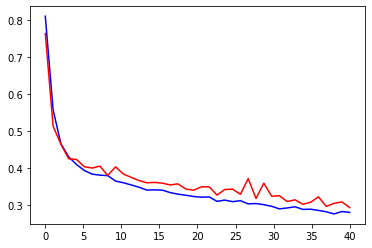

In [30]:
plt.plot(np.linspace(0,len(epoch_loss_values),len(epoch_loss_values)),epoch_loss_values,color='blue')
plt.plot(np.linspace(0,len(val_loss_values),len(val_loss_values)),val_loss_values,color='red')

Visualizing the results

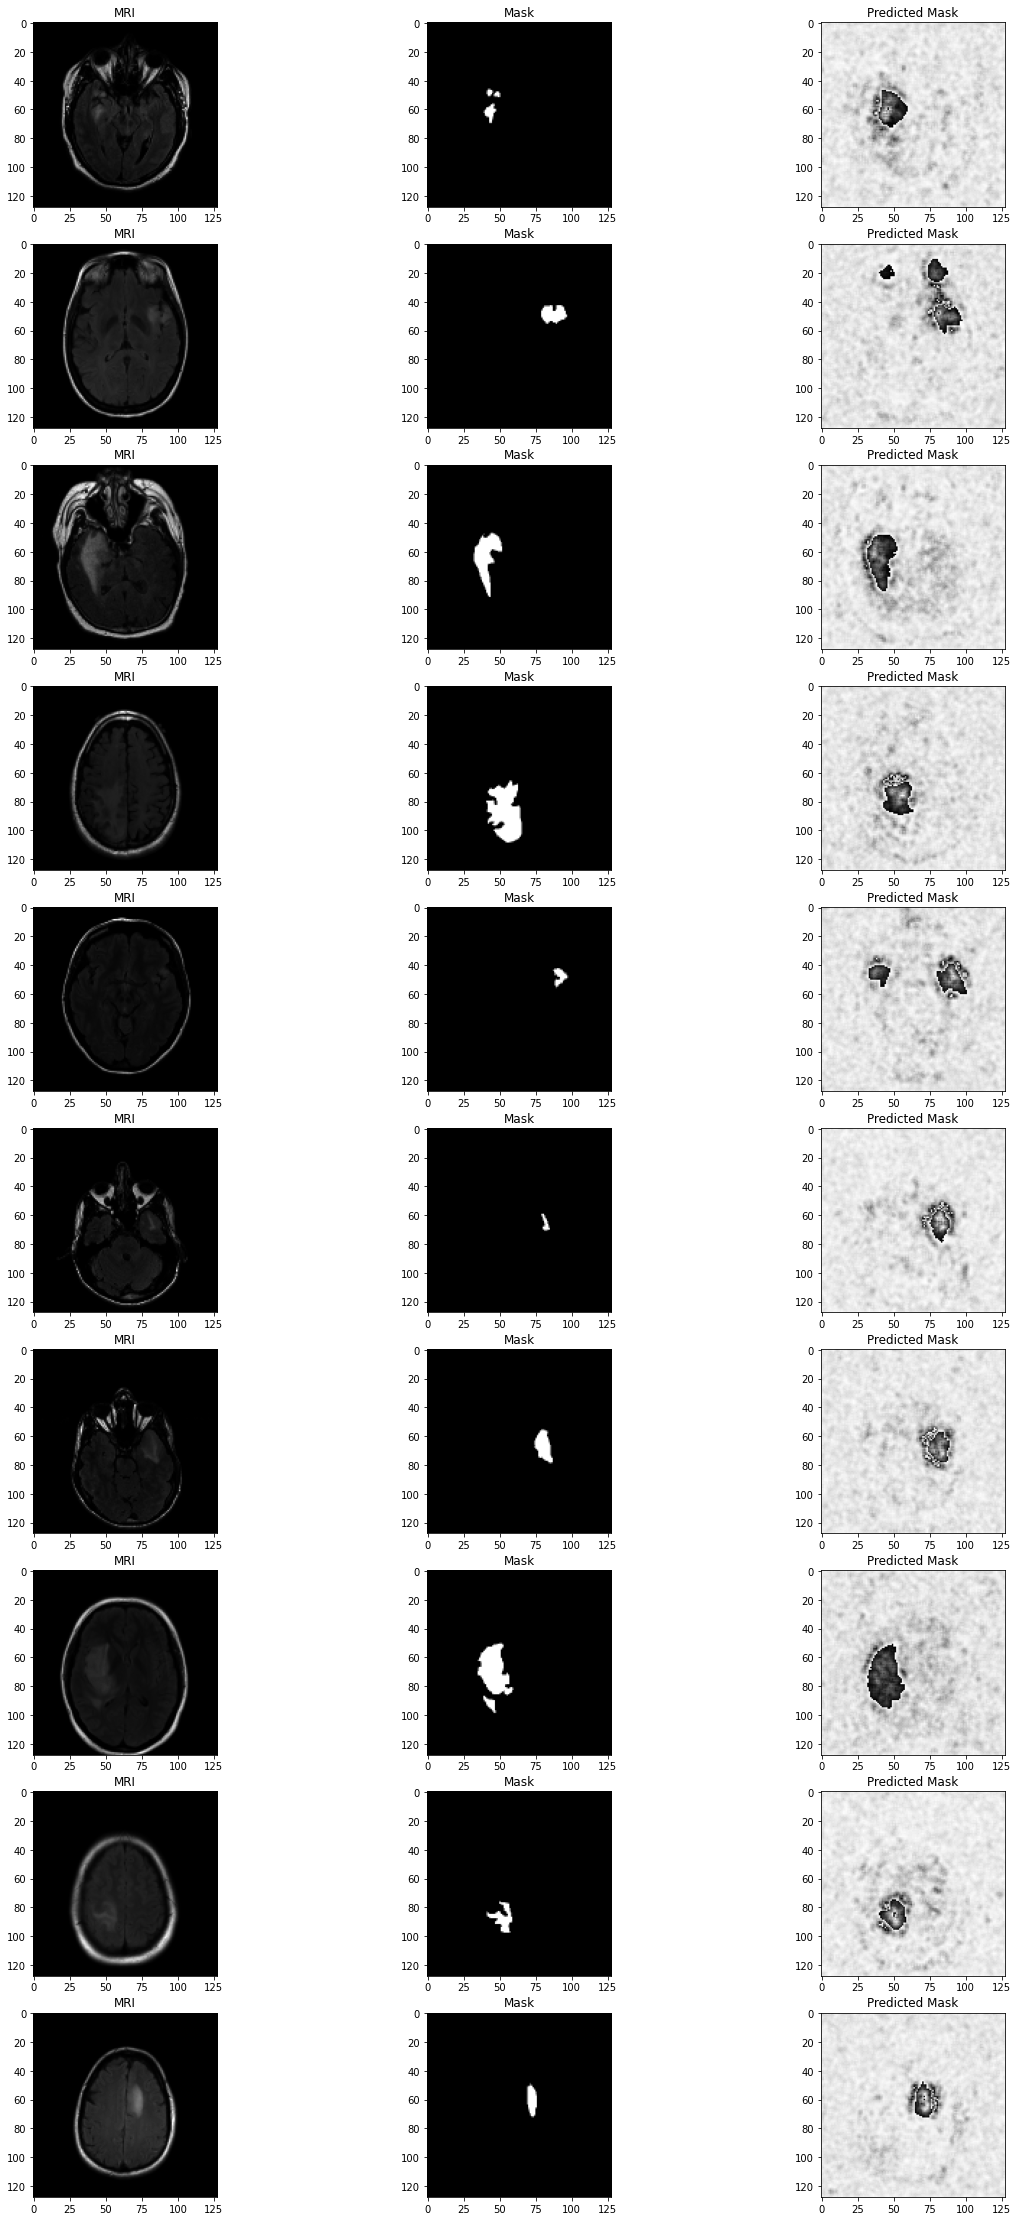

In [31]:
r = 10
i=0
fig,ax = plt.subplots(r,3,figsize=(20,40))
for batch in val_loder:
    inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
    out = model(inp).to('cpu')
    ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
    ax[i,0].title.set_text('MRI')
    ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
    ax[i,1].title.set_text('Mask')
    ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
    ax[i,2].title.set_text('Predicted Mask')
    if i>=r-1:
        break
    i=i+1